In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import regex
import os, sys
import matplotlib.pyplot as plt
import seaborn

# USER INPUTS

In [2]:
"""Experiment name to prepend output files"""
EXPERIMENT = "18014"

"""Directory path to input data 
    (filtered; output from '1-read_fastq_id_features)
"""
FILTERED_FILEPATH = "../output/filtered-18014-valid.csv"

"""Directory path to save output"""
OUTPUT_DIRECTORY = "../output/20161119"

"""Minimum number of reads as a baseline. Used to simplify data processing."""
MIN_READS = 100

# PRESETS AND SCRIPT

In [3]:
"""Column names correspoinding to eponymous variables"""

SAMPLE = 'idx'
QTAG = 'qtag'
BARCODE = 'barcode'
READS = 'readsPF'
MCOUNTS = 'mcountsPF'
PERCENT_MCOUNTS = 'percent_%s'%MCOUNTS
GROUPBY = ['idx']

# for older versions/ formats
# SAMPLE = 'idx'
# QTAG = 'qtag'
# BARCODE = 'gtag'
# READS = 'reads'
# MCOUNTS = 'molecs'
# PERCENT_MCOUNTS = 'percent_%s'%MCOUNTS
# GROUPBY = ['idx']

In [4]:
def check_inputs():
    
    # modules
    assert pd
    assert np
    assert regex
    assert os
    assert sys
    
    # user experiment inputs 
    assert EXPERIMENT
    assert FILTERED_FILEPATH
    assert OUTPUT_DIRECTORY
    assert MIN_READS
    
    # user columns
    assert SAMPLE
    assert QTAG
    assert BARCODE
    assert READS
    assert MCOUNTS
    assert PERCENT_MCOUNTS
    assert GROUPBY
    

In [5]:
def calculate_percent_molecs(df, mcounts=MCOUNTS, percent_mcounts=PERCENT_MCOUNTS):
    """Updates percent molec counters for sample"""
    total = float(df[mcounts].values.sum()) / 100.
    df[percent_mcounts] = df[mcounts].apply(lambda x: x/total)
    df = df.sort_values(by=mcounts, ascending=False)
    return df

In [6]:
def load_data(filtered_file, sample=SAMPLE, qtag=QTAG, 
              barcode=BARCODE, mcounts=MCOUNTS, reads=READS):
    """Loads filtered lib-ID-barcode data csv to dict of samples"""
    columns = [sample, qtag, barcode, mcounts, reads]
    # loads excel file (all tabs)
    csv = pd.read_csv(filtered_file)
    # filter out null barcodes just in case (if custom user input)
    csv = csv.loc[(csv[qtag]!='None') & (csv[barcode]!='None')]
    csv = csv[columns]
    csv[sample] = csv[sample].apply(lambda x: str(x))
    new_reads = csv[[reads, mcounts]].max(axis=1).values
    new_mcounts = csv[[reads, mcounts]].min(axis=1).values
    csv[reads] = new_reads
    csv[mcounts] = new_mcounts
    csv = csv.loc[csv[mcounts]>0]
    # get percent molecs per sample, store as output dict entry 
    groups = csv.groupby(sample)
    data = []
    for i, group in csv.groupby(sample):
        data.append((i,calculate_percent_molecs(group)))
    return data


In [7]:
def check_data(d, sample=SAMPLE, mcounts=MCOUNTS, reads=READS):
    """Check data for proper format, input values, and 
    converts into list-like object if necessary

    d(list, np.array ,dict, or pd.DataFrame): input data
    
    Returns: data set as a list-like object, wherein
        each item is a pair containing sample name (str) and 
        sample data (pd.DataFrame), in that order.
    """
    data_arr = []
    # wrangle data to list of list-like pairs, as "[idx, df]"
    if type(d) in [np.array, list] :
        data_arr = d
    elif type(d) == dict:
        data_arr = d.items()
    elif type(d) == pd.DataFrame :
        data_arr = [(s,df) for s,df in d.groupby(sample)]
    else:
        print "Input data is not in correct format. Please provide \
        list-like, dict, or pd.DataFrame object."
    
    # check input has correct values
    try:
        for a in data_arr:
            assert len(a) == 2, "incorrect item length"
            s, df = a
            assert type(s) == str, 'sample name is not string type'
            assert type(df) == pd.DataFrame, "incorrect value type: must be pd.DataFrame"
            assert sample in df.columns, "%s not in dataframe"%sample
            assert mcounts in df.columns, "%s not in dataframe"%mcounts
            assert reads in df.columns, "%s not in dataframe"%reads
    # if no 
    except IndexError as e:
        print "Item number of values is not 2.\n"
        print "IndexError. ",e.message
        print a
    except ValueError as e:
        print "Sample name could not be converted to float: %s\n"% type(item[i])
        print "ValueError. ",e.message
        print a
    except AssertionError as e:
        print "Assertion failed:"
        print e.message
        print a
    
    return data_arr

In [40]:
def threshold(group, reps_remaining, thresh_val, failed_df, mcounts=MCOUNTS):
    """Thresholds barcodes of a given sample

        group(pd.DataFrame): df containing library-ID-barcodes, 
            mcountsPF and percent_mcountsPF
        reps_remaining(int): reps remaining from max number 
            input from user 
        thresh_val(float or int): initial threshold value (percent_mcountPF)
            provided from previous recursion or user input
        thresh_i(int): initial position of threshold value in 
            percent_mcountsPF list, ranging [0,len(group))

        Returns: 
            None, if thresholding fails;
            passed(pd.DataFrame), if thresholding successful; or
            self, otherwise, with updated threshold values and 
                group df.
    """
    def reassign_passed(row):
        cond1 = row['passed'] == True
        cond2 = row['is_padding'] == False
        cond3 = row[mcounts] >= thresh_val
        return True if cond1&cond2&cond3 else False
        
    # max out reps
    if reps_remaining <= 0:
        print 'Maxed out reps. Skipping sample.'
    # no barcodes passed threshold 
    elif len(group) == 0:
        print "No barcodes passed threshold. Skipping sample."
    else:
        group.sort_values(by=mcounts, ascending=False, inplace=True)
        passed_mcounts = group.loc[(group['passed']==True)
                                   |(group['is_padding']==True),mcounts].values
        new_thresh_val = calculate_threshold(passed_mcounts)
        
        # if reached steady state
        if new_thresh_val == thresh_val:
            group.loc[:,'passed'] = group.apply(reassign_passed, axis=1)
            group.reset_index(inplace=True,drop=True)
            print thresh_val, len(group[(group['passed']==True)]), len(group)
            sys.stdout.write('Thresholded.\n')  
            return group, failed_df
        # recursively clean and re-threshold
        else:
            cleaned, failed_updated = eliminate_oneoffs(group,new_thresh_val,failed_df)
            cleaned.reset_index(inplace=True,drop=True)
            # recurse with cleaned df and new threshold values
            return threshold(cleaned, reps_remaining-1, new_thresh_val, failed_updated,
                             mcounts)
        
    # if thresholding failed, return None
    sys.stdout.write('Skipped.\n')
    return pd.DataFrame()

In [9]:
# STEP 2: CALCULATE THRESHOLD via. CONCAVITY


def calculate_threshold(y):
    """Calculates threshold of series with modified concavity approach

        y(np.array or list): list or list-like object of 
            values as floats or ints

        Returns index of inflection point in array, 
            i.e. threshold position.
    """
    def rolling_window(arr):
        """Constructs list of overlapping subarray ranges of size 2"""
        shape = arr.shape[:-1] + (arr.shape[-1]-1, 2)
        strides = arr.strides + (arr.strides[-1],)
        windows = np.lib.stride_tricks.as_strided(arr, 
                              shape=shape, strides=strides)
        return windows
    def first_d_gen(windows):
        """Generates first derivative of windows as relative difference"""
        for w in windows:
            # amended 2016-10-12: normalize by y midpoint instead of second point to 
            # better represent the count magnitude of segment
            yield float(w[1]-w[0])/(w[0]+w[1])*2
    def second_d_gen(windows):
        """Generates second derivative of windows"""
        for w in windows:
            yield w[1]-w[0]         
    
    y_temp = sorted(y, reverse=True)
    
    # left and right padding to cover all array vals in derivations
    yarray = np.concatenate([ [y_temp[0]], y_temp, [1] ])
    # calculates first derivative
    first_windows = rolling_window(yarray)
    first_derivs = np.fromiter(first_d_gen(first_windows), np.float
                               , count=len(first_windows))
    # calculates second derivative
    second_windows = rolling_window(first_derivs)
    second_derivs = np.fromiter(second_d_gen(second_windows), np.float
                                , count=len(second_windows))
    # gets index or position value of inflection point (curves down ), adjust by adding 1
    thresh_i = min(np.argmin(second_derivs)+1, len(y_temp)-1)
    thresh_v = y_temp[thresh_i]
    return thresh_v

In [10]:
def eliminate_oneoffs(group, thresh_val, failed_df, pad=True,reads=READS,
                      qtag=QTAG, barcode=BARCODE,mcounts=MCOUNTS):
    """Eliminate barcodes that are one position off from a more-abundant barcode
        group(pd.DataFrame): df containing qtag, barcode, and percent_mcounts columns
        thresh_val(float): threshold value to select high abundant barcodes
            to iterate through as 'major' ones
        pad(bool): if True, adds a right pad so last non-eliminated value 
            can be analyzed in by the threshold() function. Default True.
        qtag, barcode, percent_mcounts, mcounts (str): column names for the corresponding
            argument. Defaults are global vars QTAG, BARCODE, PERCENT_MCOUNTS, MCOUNTS.

        Returns: table of barcodes that passed elimination
    """
    group.loc[:,'is_padding'] = group[mcounts].apply(lambda _: False)
    failed_toadd = group.loc[(group['passed']==True)&(group[mcounts]<thresh_val)].copy()
#     group.loc[:,'passed'] = group.apply(lambda x: True if x[mcounts] >= thresh_val else False, axis=1)
    counter = 0
    failed_arr = []
    cols = ['idx',qtag,barcode,mcounts,reads]
    group.sort_values(by=mcounts, ascending=False,inplace=True)
#     print thresh_val, len(group.loc[group['passed']==True]), len(group.loc[group[mcounts]>=thresh_val])
#     def init_failed_entry(minor, major, barcode_error):
#         new_row = pd.Series()
#         for col in cols:
#             new_row[col] = row[col]
#         new_row['qtag_mismatch'] = True if qtag_vals==True else False
#         new_row['barcode_error'] = True if sum(barcode_error) > 0 else False
#         return new_row

    # add capability to check other parameters, i.e. qtag
#     print len(group)," @ ",len(group.loc[group['passed']==True])
    for majorI, majorRow in group.loc[ (group['passed']==True)
                                      &(group[mcounts] >= thresh_val)].iterrows():
        # if it has not yet been tested
        if majorRow['passed'] == True:
            subgroup = group[counter+1:].loc[
                (group['passed']==True) & (group[mcounts]<majorRow[mcounts])]
            # for each 'minor' barcode aka. with fewer molecs, test if one-off from major
            for minorI, minorRow in subgroup.iterrows():
                query = regex.search("(%s){s<=1}" % majorRow[barcode],
                                     minorRow[barcode])
                if query:
                    group.loc[minorI, 'passed'] = False
                    qtags_diff = minorRow[qtag] == majorRow[qtag]
                    barcode_errors = sum(query.fuzzy_counts) > 0
                    group.loc[minorI, 'qtag_mismatch'] = qtags_diff==False
                    group.loc[minorI, 'barcode_error'] = barcode_errors
                    failed_arr.append(group.loc[minorI,:])
        counter+=1
        
        
    group.loc[:,'passed'] = group.apply(lambda x: False if x[mcounts]<thresh_val 
                                        else x['passed'], axis=1)
    # select barcodes which pass, ie. are not eliminated
#     output = group.loc[(group['passed']==True) & (group[mcounts] >= thresh_val)]
    output = group
    to_concat = [failed_df]
    if len(failed_arr) > 0:
        failed_arrdf = pd.DataFrame(failed_arr)
        to_concat.append(failed_arrdf)
        
    if len(failed_toadd) > 0:
        to_concat.append(failed_toadd)
    failed_updated = pd.concat(to_concat) if len(to_concat) > 1 else failed_df
    # if requested, adds a right pad  
    # line added 2016-10-12: combine two conditions: ensure that 
    # no null rows get added if all barcodes are accepted
    
    
    
    if pad==True and len(group) != len(group['passed']==True):
        deletes = group.loc[(group['passed']==False) & (group[mcounts]<thresh_val)][mcounts]
#         if len(deletes) > 0:
        max_i = deletes.idxmax()
#         output.append(group.loc[max_i,:])
        output.loc[max_i,['is_padding']] = [True]
#     print output.head(), "\n"
    return output, failed_updated
            

In [45]:
def run_threshold(d, sample=SAMPLE, qtag=QTAG, barcode=BARCODE, 
                  mcounts=MCOUNTS, reads=READS,
                  min_reads=MIN_READS, min_mcount=50):
    """Run threshold algorithm for each sample in dataset

        d(np.array, list, dict, or pd.DataFrame): dataset for all samples
        sample, qtag, barcode, mcounts, reads, percent_mcounts(str): columns in df for 
            corresponding vals. Defaults are global vars SAMPLE, QTAG, BARCODE, MCOUNTS, 
            READS, PERCENT_MCOUNTS.
        min_reads(int): minimum number of reads for a library-ID-barcode as an 
            absolute baseline (that which any barcode below is highly likely to be 
            false.) Default is global var MIN_READS.
        min_mcount(int): minimum number of molecs for library-ID-barcode as an
            absolute baseline. Default is 50.

        Note: min_reads and min_mcount are applied to increase performance.

        Returns: 
            pd.DataFrame, if successful, of 'true' (passed) library-ID-barcodes 
                for all samples
            None, if no samples had passing library-ID-barcodes.
    """
    passed = []
    failed = []
    counter = 1
    # checks and formats data (d) to list-like obj of pairs
    data_arr = check_data(d, sample=sample, mcounts=mcounts, reads=reads)
    # run for each (sample, df) in dataset 
    for s, group in data_arr:
        sys.stdout.write("Sample %d of %d (%s): "%(counter,len(data_arr),s))
        # select valid data meeting absolute baseline 
        group = group.loc[(group[qtag] != 'None') & (group[barcode] != 'None') ]
#                           & (group[mcounts] > min_mcount)
#                           & (group[reads] > min_reads)]
        if len(group) > 0 and sum(group[mcounts]) > 1000:
            group.loc[:,'passed'] = True
            group.loc[:,'is_padding'] = False
            group.loc[:,'barcode_error'] = False
            group.loc[:,'qtag_mismatch'] = False

            result, failed_idx = threshold(group, 20, -1, pd.DataFrame(), mcounts)
            passed.append(result)
            failed.append(failed_idx)
        sys.stdout.flush()
        counter += 1
    # if we do have data (i.e. some barcodes that passed in the samples)
    if len(passed) > 0:
        # concat all df together
        passeddf = pd.concat(passed)
        # formatting
        passeddf.sort_values(by=[sample,mcounts]
                             ,ascending=[True, False]
                             ,inplace=True)
        passeddf.reset_index(inplace=True,drop=True)
        faileddf = pd.concat(failed)
        return passeddf, faileddf
    else:
        print "No samples were successfully thresholded."
    return 

### SCRIPT TO SAVE DATA TO CSVs

In [12]:
def save_data(filtered,passed, output_directory=OUTPUT_DIRECTORY, experiment=EXPERIMENT):
    
    # Save passed dataframe
    passed.to_csv('%s/threshold-%s-passed.csv'%(output_directory,experiment), index=False)
    # count and save results
    counts = count_sample_barcodes(passed)
    counts.to_csv('%s/threshold-%s-counts.csv'%(output_directory,experiment), index=False)
    # merge passed and filtered data and save
    fc_temp = pd.concat([d[1] for d in filtered])
    filtered_concat = apply_passed_data(fc_temp, passed)
    filtered_concat.to_csv('%s/threshold-%s-merged.csv'%(output_directory,experiment), index=False)

In [13]:
def count_sample_barcodes(df, groupby=SAMPLE, barcode=BARCODE, sample=SAMPLE, qtag=QTAG
                      , percent_mcounts=PERCENT_MCOUNTS):
    """Counts passed barcodes per sample and saves as csv
    
        df(pd.DataFrame): input dataframe containing passed 
            barcodes of all samples
        groupby(str or list-like): columns to group samples by
    """
    agg = df.groupby(groupby).agg(len)
    counts = agg[agg.columns[0]]
    counts.name = 'count'
    counts = pd.DataFrame(counts)
    counts.reset_index(inplace=True)
    return counts



In [14]:
def apply_passed_data(filtered, passed, sample=SAMPLE, qtag=QTAG
                      , barcode=BARCODE, percent_mcounts=PERCENT_MCOUNTS):
    """Cross reference passed barcodes with raw filtered data
        filtered(pd.DataFrame): raw filtered data as dataframe for all samples
        passed(pd.DataFrame): data passed threshold (output of run_threshold)
        sample,qtag,barcode,percent_mcounts(str): names corresponding to df columns.
            Defaults are SAMPLE,QTAG,BARCODE,PERCENT_MCOUNTS.

        Returns:
            filtered(pd.DataFrame) updated with 'passed_threshold' and 
            percent_mcounts columns
    """
    def cross_ref_passed(row):
        key = (row[sample],row[qtag],row[barcode])
        if key in passed_indexed.index:
            row[percent_mcounts+'_thresholded'] = passed_indexed.loc[key,percent_mcounts]
            row['passed_threshold'] = True
        return row

    passed_indexed = passed.set_index([sample,qtag,barcode])
    filtered.rename(columns={percent_mcounts:percent_mcounts+'_filtered'})
    filtered['passed_threshold'] = False
    filtered[percent_mcounts+'_thresholded'] = 0
    filtered = filtered.apply(cross_ref_passed, axis=1)
    return filtered



# EXECUTE SCRIPT BELOW

In [55]:
if __name__=='__main__':
    # Check all inputs exist and are valid
    check_inputs()
    # Runs data loading in script
    filtered = load_data(FILTERED_FILEPATH)
    # Run thresholding of all samples in dataset
    passed, failed = run_threshold(filtered)
#     save_data(filtered, passed, output_directory=OUTPUT_DIRECTORY, experiment=EXPERIMENT)

Sample 1 of 19 (1): 67 22 2
22  @  22
21979 1 1
22  @  1
21979 1 22
1 22
Thresholded.
Sample 2 of 19 (180-10): 878 68 2
68  @  68
878 2 68
2 68
Thresholded.
Sample 3 of 19 (180-12): 74 33 3
33  @  33
74 3 33
3 33
Thresholded.
Sample 4 of 19 (2): 98 28 2
28  @  28
61172 1 1
28  @  1
61172 1 28
1 28
Thresholded.
Sample 5 of 19 (20): 118 38 2
38  @  38
189720 1 1
38  @  1
189720 1 38
1 38
Thresholded.
Sample 6 of 19 (21): 31 18 2
18  @  18
13456 1 1
18  @  1
13456 1 18
1 18
Thresholded.
Sample 7 of 19 (22): 316 40 2
40  @  40
166365 1 1
40  @  1
166365 1 40
1 40
Thresholded.
Sample 8 of 19 (23): 24 24 2
24  @  24
15262 1 1
24  @  1
15262 1 24
1 24
Thresholded.
Sample 9 of 19 (24): 52 28 2
28  @  28
21939 1 1
28  @  1
21939 1 28
1 28
Thresholded.
Sample 10 of 19 (25): 38 24 2
24  @  24
42568 1 1
24  @  1
42568 1 24
1 24
Thresholded.
Sample 11 of 19 (26): 18 22 2
22  @  22
21539 1 1
22  @  1
21539 1 22
1 22
Thresholded.
Sample 12 of 19 (27): 21 26 2
26  @  26
21 2 26
2 26
Thresholded.
Sampl

/Users/vivianleung/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [58]:
merged = passed
merged.drop([PERCENT_MCOUNTS, 'is_padding'],axis=1, inplace=True)

In [73]:
merged.to_csv('../output/thresholded_merged-%s-20161119.csv'%(EXPERIMENT))

## GRAPHING

In [60]:
itypes = {
    (True,False,False):'passed', #passed
    (False,True,False):'qtag mismatch', #qtag error
    (False,False,True):'barcode oneoff', #barcode error
    (False,False,False):'other error', #not one-off
    (False,True,True):'other error'
}

for itype in itypes:
    keys = ['passed','qtag_mismatch','barcode_error']
    ca = [(merged[k]==v) for k,v in zip(keys,itype)]
    cond = ca[0]&ca[1]&ca[2]
    merged.loc[(cond),'itype'] = itypes[itype]
    
ctypes = {
    'passed':'#11BF08',
    'barcode oneoff': '#DE092B',
    'qtag mismatch':'#EBA709',
    'other error':'#2A52D5'
}
itype_order = [
    'passed',
    'other error',
    'barcode oneoff',
    'qtag mismatch'
]

In [61]:
seaborn.set_style('white')
seaborn.despine()

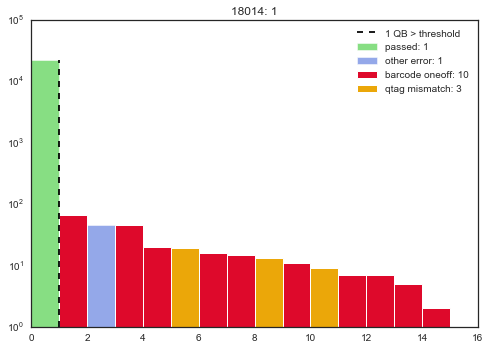

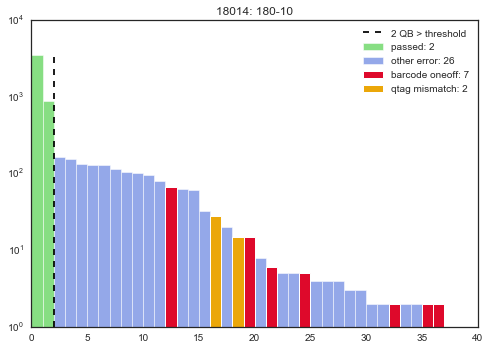

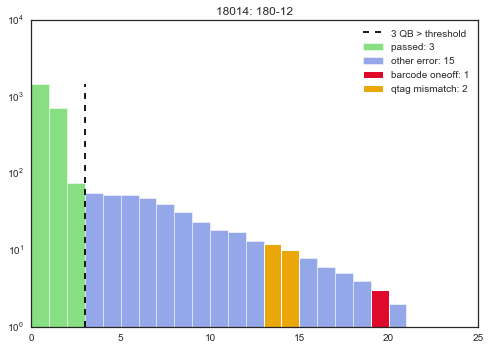

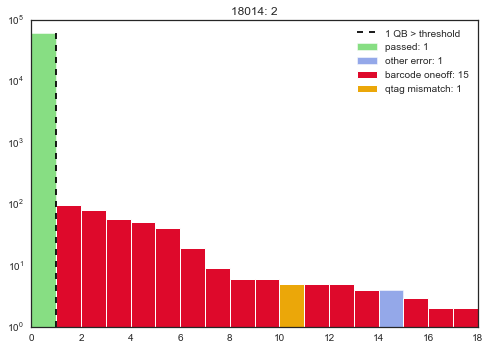

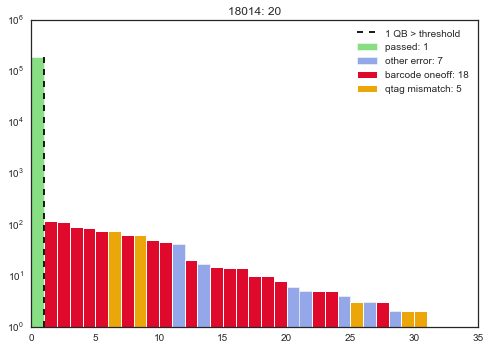

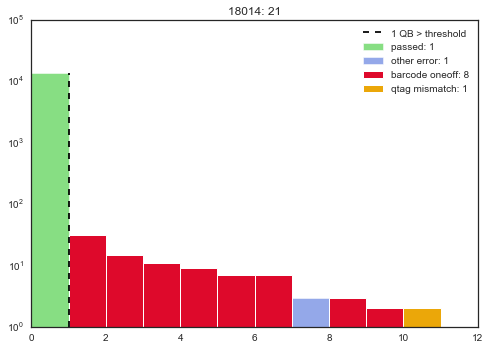

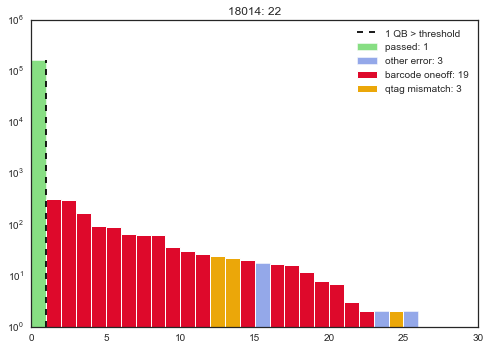

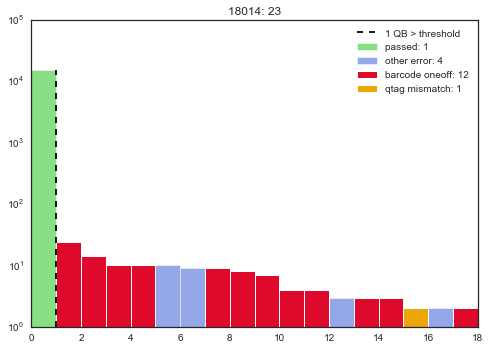

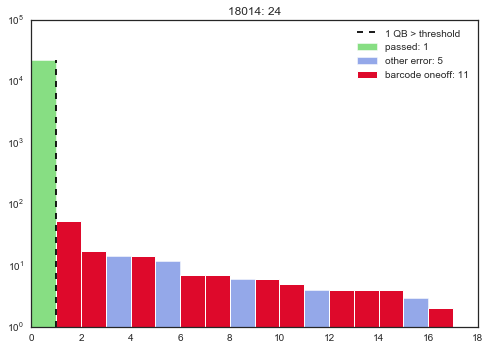

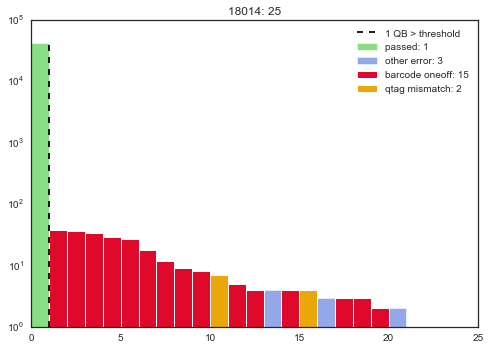

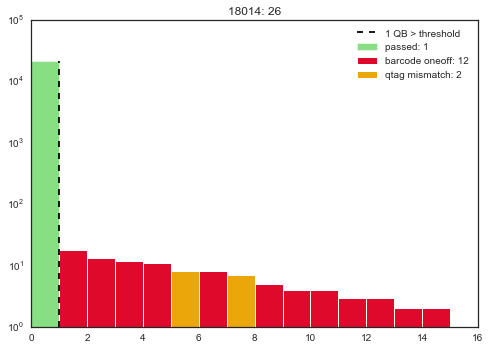

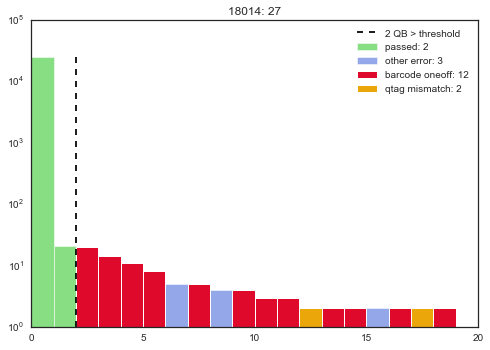

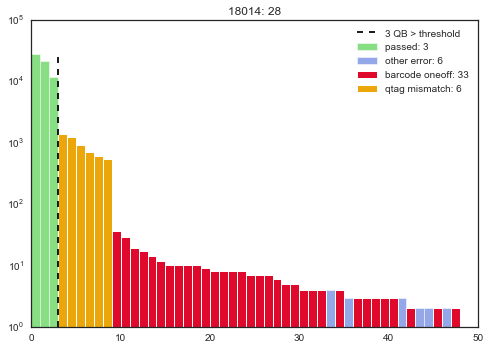

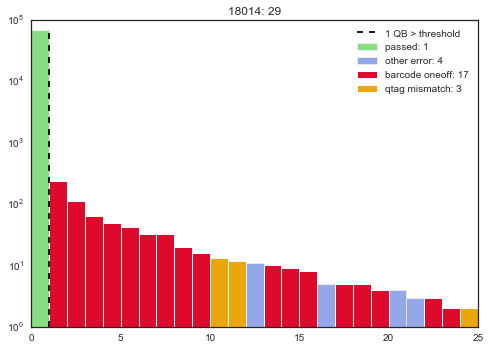

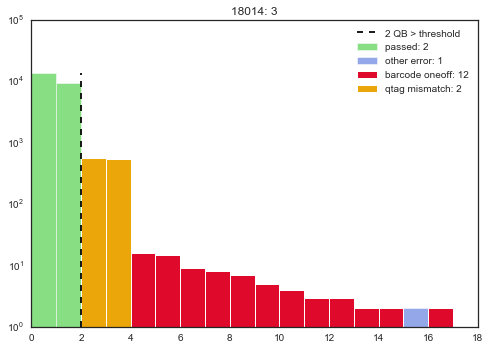

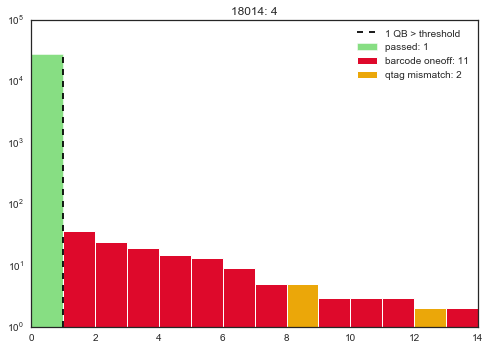

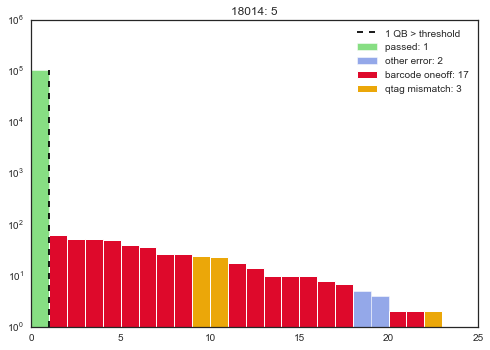

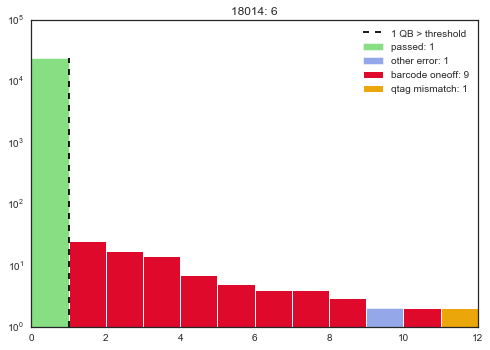

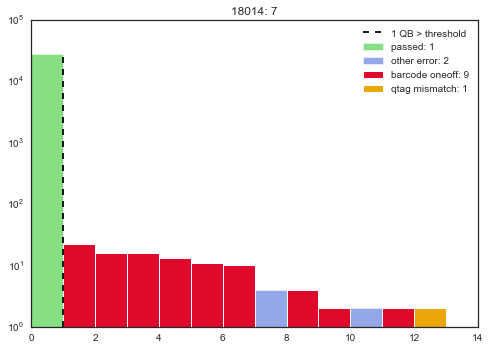

In [72]:
# plots scatter
plottype = 'bar'
mcounts=MCOUNTS
counter = 0
for idx, group in merged.groupby('idx'):
#     if idx[:2]=='NH':
    if group[mcounts].sum()>1000:
        gslice = group.sort_values(by=mcounts,ascending=False)
        gslice = gslice.loc[gslice[mcounts]>1]
        counts = gslice[mcounts].values
        itypes = gslice.itype.values
        it_present= np.unique(itypes)
        
        f, ax = plt.subplots(1)
        for itype in itype_order:
            if itype in it_present:
                x = np.where(itypes==itype)[0]
                y = counts[x]
                label = "%s: %d"%(itype,len(x))
                color = ctypes[itype]
                alpha = 0.5 if itype in ['passed','other error'] else 1
                edgecolor=color
                lw = 1.5
                s = 250 if itype in ['barcode oneoff','qtag mismatch'] else 8
                marker = "|" if itype in ['barcode oneoff','qtag mismatch'] else "-o-"
                    
                if plottype == 'scatter':
                    ax.scatter(x+1, y, color=color, edgecolors=edgecolor,
                            alpha=alpha, label=label, 
                            marker=marker, lw=lw, s=s)
                    
                else:
                    ax.bar(x, y, color=color, alpha=alpha, 
                           label=label, lw=1,edgecolor='white', width=1 )
        
        thresh_line =np.max(np.where(itypes=='passed')[0])+1
        ax.plot([thresh_line,thresh_line],[1,max(counts)], 
                color = 'black', alpha = 1, ls = '--',
                label='%d QB > threshold'%(thresh_line))
        
        ax.set_yscale('log')
        ax.set_xlim(0)
        ax.legend()
        ax.set_title(EXPERIMENT+": "+idx)
        f.savefig('../output/figs-20161119/%s_%s.png'%(EXPERIMENT, idx))
#         break


    